<a href="https://colab.research.google.com/github/evakatha/Horse_Racing_Win_Prediction/blob/main/HorseRacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horse Racing Win Prediction

In [4]:
## Importing libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc

In [5]:
## Importing horse dataset from Kaggle

path = kagglehub.dataset_download("ahmedabdulhamid/horse-racing")

print("Path to dataset files:", path)

print("Files in dataset folder:")
print(os.listdir(path))

Path to dataset files: /kaggle/input/horse-racing
Files in dataset folder:
['HorseRacing.csv']


In [6]:
csv_file = "/kaggle/input/horse-racing/HorseRacing.csv"

df = pd.read_csv(csv_file)

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (13128, 428)
  Course country              Course date  Abandoned  Runners  Non-runners  \
0        England  Sunday November 1, 2020      False        6            0   
1        England  Sunday November 1, 2020      False        6            0   
2        England  Sunday November 1, 2020      False        6            0   
3        England  Sunday November 1, 2020      False        6            0   
4        England  Sunday November 1, 2020      False        6            0   

  Course name Course time                                               Name  \
0    Carlisle       13:35  Gordon Richards Novices Limited Handicap Chase...   
1    Carlisle       13:35  Gordon Richards Novices Limited Handicap Chase...   
2    Carlisle       13:35  Gordon Richards Novices Limited Handicap Chase...   
3    Carlisle       13:35  Gordon Richards Novices Limited Handicap Chase...   
4    Carlisle       13:35  Gordon Richards Novices Limited Handicap Chase...   

  Distance Race type  

# EDA

The target is Top 1. We want to find out which of these factors has the highest impact on a horse winning:
* Age
* Days
* Win Odds
* Horse nationality
* Trainer name
* Jockey name
* Distance
* Going

We also want to train a model that can accurately predict if a horse wins.

In [7]:
target = "Top1"
features = ["Age", "Days", "Win Odds", "Horse nationality", "Trainer name", "Jockey name", "Distance", "Going"]

df_model = df[features + [target]].copy()

In [8]:
# Encoding categories for models
for col in ["Horse nationality", "Trainer name", "Jockey name", "Distance", "Going"]:
    df_model[col] = df_model[col].astype("category").cat.codes

In [9]:
# Dropping missing values and checking dataset
df_model = df_model.dropna()

print("Shape after cleaning:", df_model.shape)
print("Win rate in dataset:", df_model[target].mean())

Shape after cleaning: (13128, 9)
Win rate in dataset: 0.11311700182815357


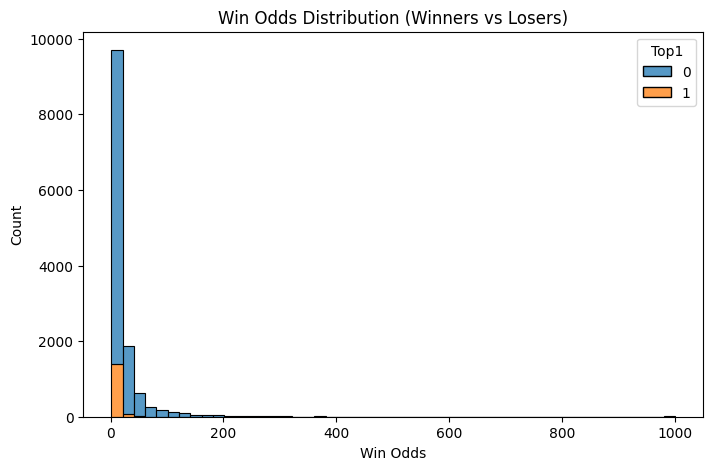

In [13]:
# Win Odds distribution check
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_model,
    x="Win Odds",
    hue="Top1",
    bins=50,
    multiple="stack"
)
plt.title("Win Odds Distribution (Winners vs Losers)")
plt.xlabel("Win Odds")
plt.show()

Shows high impact of win odds. Most winners are concentrated at lower win odds (favourites).

# Train/Test Split



In [14]:
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Quick Model Comparison (Baseline)

Checking Logistic Regression, Random Forest and XGBoost

In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    results.append({"Model": name, "Accuracy": acc, "ROC AUC": roc})

results_df = pd.DataFrame(results)
print("\nBaseline Model Comparison:")
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:22:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Baseline Model Comparison:
                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.886900  0.733973
1        Random Forest  0.889185  0.697823
2              XGBoost  0.880807  0.667119


Logistic Regression shows high ROC AUC -> can predict winners/losers with 73% accuracy

For feature importance, Random Forest is better since it shows non-linear relationships (important in complex relationships such as horse racing)

In [18]:
# Baseline Logistic Regression
baseline_lr = LogisticRegression(max_iter=1000, random_state=42)
baseline_lr.fit(X_train, y_train)
y_pred_baseline = baseline_lr.predict(X_test)
y_prob_baseline = baseline_lr.predict_proba(X_test)[:,1]

print("\nBaseline Logistic Regression Performance (No Class Weighting):")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("ROC AUC:", roc_auc_score(y_test, y_prob_baseline))
print(classification_report(y_test, y_pred_baseline))


Baseline Logistic Regression Performance (No Class Weighting):
Accuracy: 0.8869002284843869
ROC AUC: 0.7339734832220878
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2329
           1       0.00      0.00      0.00       297

    accuracy                           0.89      2626
   macro avg       0.44      0.50      0.47      2626
weighted avg       0.79      0.89      0.83      2626



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


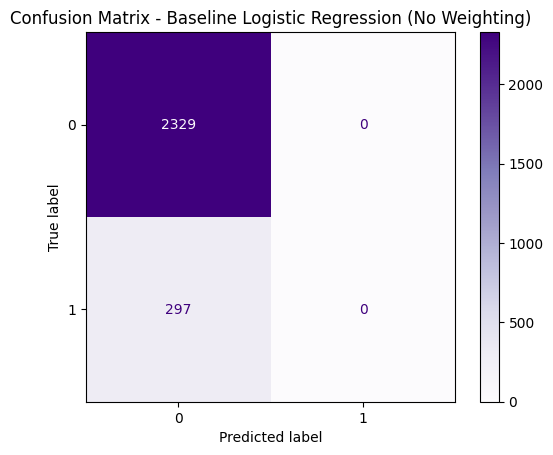

In [22]:
# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
ConfusionMatrixDisplay(cm_baseline).plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Baseline Logistic Regression (No Weighting)")
plt.show()

The model doesn't predict any winners. The dataset is heavily imbalanced. We need to balance it.

# Class-weighted Logistic Regression

In [20]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print("\nLogistic Regression (Balanced) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression (Balanced) Performance:
Accuracy: 0.5251332825590251
ROC AUC: 0.7290032137606204
              precision    recall  f1-score   support

           0       0.95      0.49      0.65      2329
           1       0.17      0.81      0.28       297

    accuracy                           0.53      2626
   macro avg       0.56      0.65      0.46      2626
weighted avg       0.87      0.53      0.60      2626



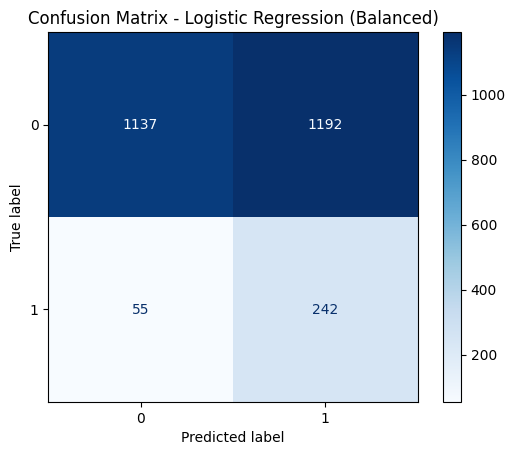

In [21]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (Balanced)")
plt.show()

Half of losing horses were correctly predicted.

Other half were incorrectly predicted as losing --> that's to be expected, since we traded accuracy for better winner detection

Very few missed winners (55) --> 81% were accurately predicted (242 / (242 + 55))

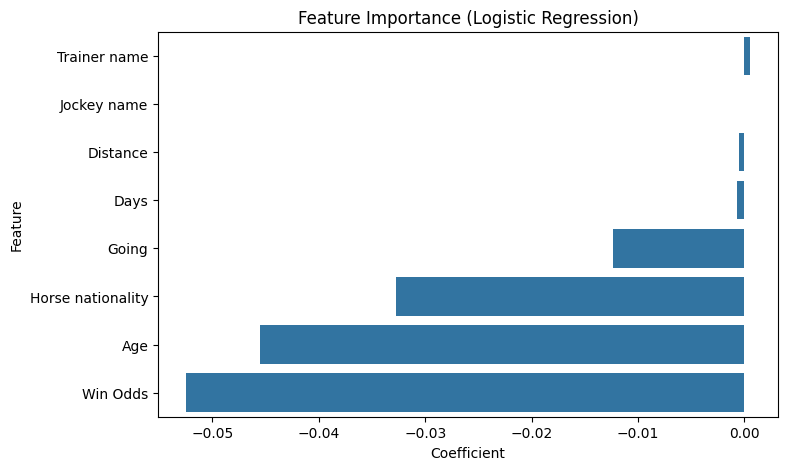

             Feature  Coefficient
4       Trainer name     0.000506
5        Jockey name    -0.000026
6           Distance    -0.000472
1               Days    -0.000679
7              Going    -0.012332
3  Horse nationality    -0.032779
0                Age    -0.045531
2           Win Odds    -0.052467


In [23]:
# Checking feature importance to winning

coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": log_reg.coef_[0]}).sort_values(by="Coefficient", ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Feature Importance (Logistic Regression)")
plt.show()
print(coef_df)

High importance of win odds is to be expected (favourites win more often). Great importance of horse nationality and relatively low for jockey and trainer is unexpected. Check Random Forest for non-linear relationships.

# Random Forest (class-weighted)

Checking Random Forest which features are most important requirements for winning. Random Forest is best for catching non-linear relationships (important in horse racing).

In [24]:
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\nRandom Forest (Balanced) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest (Balanced) Performance:
Accuracy: 0.8869002284843869
ROC AUC: 0.6985570605149822
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2329
           1       0.50      0.02      0.04       297

    accuracy                           0.89      2626
   macro avg       0.69      0.51      0.49      2626
weighted avg       0.84      0.89      0.84      2626



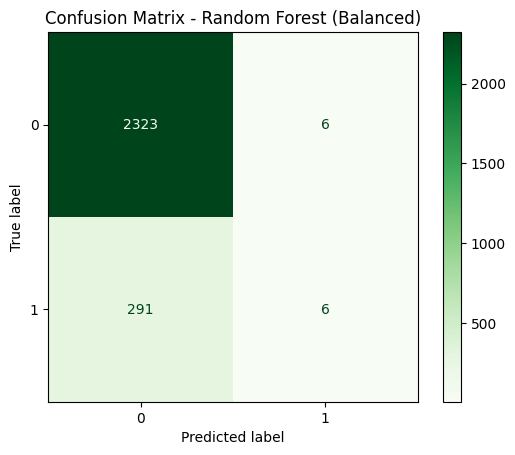

In [25]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Random Forest (Balanced)")
plt.show()

Many falsely predicted losers, missing most winners. Not a good model for predicting winners.

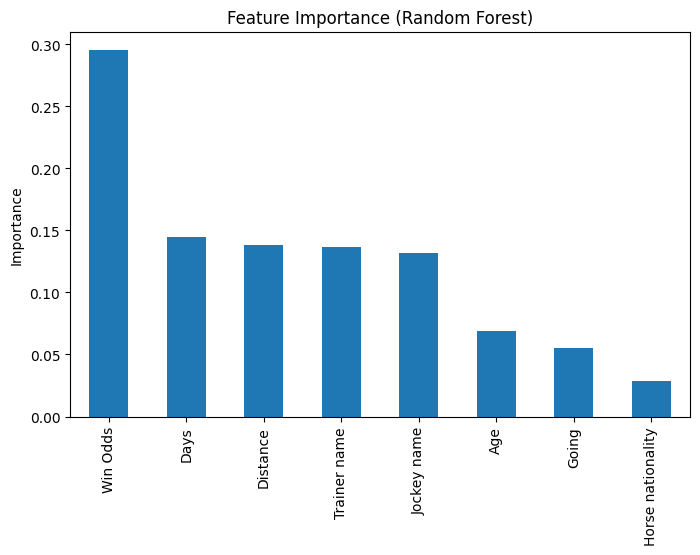

             Feature  Importance
0           Win Odds    0.295521
1               Days    0.144303
2           Distance    0.138548
3       Trainer name    0.136889
4        Jockey name    0.131504
5                Age    0.069036
6              Going    0.055470
7  Horse nationality    0.028728


In [26]:
# Feature importance

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.plot(kind="bar")
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()
importance_df = pd.DataFrame({"Feature": importances.index, "Importance": importances.values})
print(importance_df)

High importance of win odds (as predicted) and days since the last time the horse ran. Least important is horse's nationality and track condition.

# Precision-Recall Curve

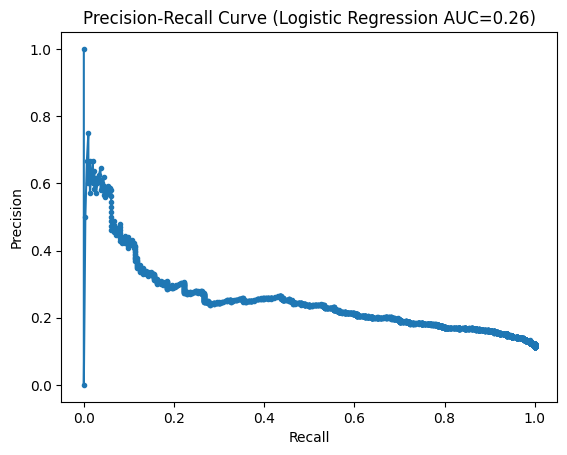

In [27]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, marker='.')
plt.title(f"Precision-Recall Curve (Logistic Regression AUC={pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

The model accurately predicts a few of the winners (60% of predicted winners is correct). These are likely the top sure bets but the model only catches ~10% of all winners. The more winners the model tries to predict, more false positives arise.

When the model tries to guess all the winners, it's not much more accurate than random guess (~11%).

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:57:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


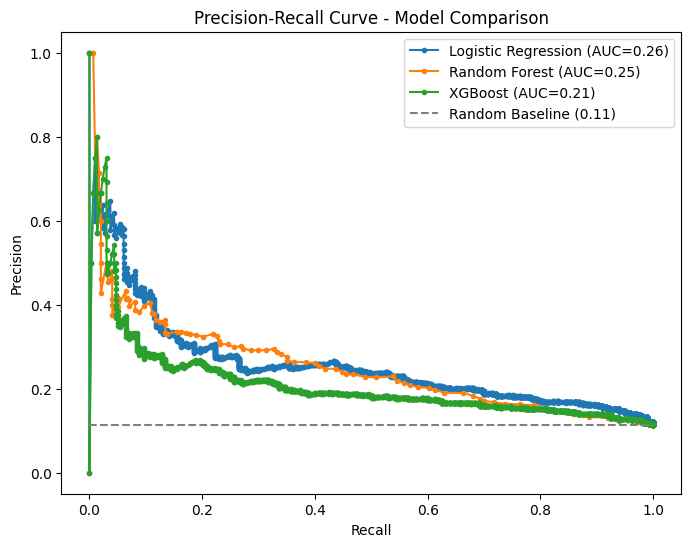

In [28]:
# Checking PR-Curve for multiple models

def plot_pr_curves(models, X_test, y_test):
    plt.figure(figsize=(8,6))

    for name, y_prob in models.items():
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, marker='.', label=f"{name} (AUC={pr_auc:.2f})")

    # Baseline precision (random guess)
    baseline = y_test.mean()
    plt.hlines(baseline, 0, 1, colors='gray', linestyles='dashed', label=f"Random Baseline ({baseline:.2f})")

    plt.title("Precision-Recall Curve - Model Comparison")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Prepare model probabilities
model_probs = {
    "Logistic Regression": y_prob_lr,
    "Random Forest": y_prob_rf,
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42).fit(X_train, y_train).predict_proba(X_test)[:,1]
}

plot_pr_curves(model_probs, X_test, y_test)

Random Forest and XGBoost can 100% very few winners. But they struggle at predicting other winners. Both show some peaks where they have higher precision-recall than logistic regression, but that's due to both models being non-linear and being able to pick up few strong signals.

Overall, Logistic Regression is more consistent across thresholds and XGBoost/Random Forest can overfit to strong signals.